In [65]:
%pwd

'/users/xpb20111/programs/benchmark_models'

In [68]:
%ls /users/xpb20111/Solubility/Datasets/From_Jonny/From_Jonny.csv

combined_data_v4_without_paclitaxel_or_salts.csv
Effect_of_duplicates_on_RF_model.ipynb
From_Jonny.csv
From_Jonny_RISM.csv
Load_data.ipynb
Possible_duplicates_for_Jonny.csv


In [135]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr, spearmanr

import numpy as np
import pandas as pd
import pickle as pk

import matplotlib.pyplot as plt
%matplotlib inline

In [136]:
# Plot correlation plot and calculate statistics:
def plt_scatter(x, y):
    plt.scatter(x, y, s=6)

    axmin = min([x.min(), y.min()])
    axmax = max([x.max(), y.max()])
    plt.xlim([axmin - 0.5, axmax + 0.5])
    plt.ylim([axmin - 0.5, axmax + 0.5])

    m, c = np.polyfit(x, y, 1)
    plt.plot([axmin, axmax], m*np.array([axmin, axmax]) + c)
    plt.plot([axmin, axmax], [axmin, axmax], ls='--', c='black')
    plt.xlabel('Experimental value')
    plt.ylabel('Predicted value')
    plt.gca().set_aspect('equal')

    plt.text(1.1, 0.95, 
        "y = {:.3f} x + {:.3f}\n\n".format(m, c) + \
        "Pearson r: {:.3f}\n".format(pearsonr(x, y)[0]) + \
        "Spearman r: {:.3f}\n\n".format(spearmanr(x, y)[0]) + \
        "R2: {:.3f}\n".format(r2_score(x, y)) + \
        "RMSD: {:.3f}\n".format(mean_squared_error(x, y)**0.5) + \
        "(SD_exp: {:.3f})\n".format(np.std(x)) + \
        "Bias: {:.3f}\n".format(np.mean(x - y)) + \
        "SDEP: {:.3f}\n".format(np.mean(((x - y) - np.mean(x - y))**2)**0.5),
        verticalalignment='top',
        transform=plt.gca().transAxes)
    plt.show()

In [87]:
%ls ~/Downloads -ltr

total 133885
-rw-r--r--  1 xpb20111 users    86592 Dec 22  2016 ct-2016-00794e-File018.pdb
-rw-r--r--  1 xpb20111 users    86355 Dec 22  2016 ct-2016-00794e-File017.pdb
-rw-r--r--  1 xpb20111 users    86355 Dec 22  2016 ct-2016-00794e-File016.pdb
-rw-r--r--  1 xpb20111 users    86434 Dec 22  2016 ct-2016-00794e-File015.pdb
-rw-r--r--  1 xpb20111 users    86750 Dec 22  2016 ct-2016-00794e-File014.pdb
-rw-r--r--  1 xpb20111 users    86671 Dec 22  2016 ct-2016-00794e-File013.pdb
-rw-r--r--  1 xpb20111 users    86592 Dec 22  2016 ct-2016-00794e-File012.pdb
-rw-r--r--  1 xpb20111 users    86355 Dec 22  2016 ct-2016-00794e-File011.pdb
-rw-r--r--  1 xpb20111 users    86276 Dec 22  2016 ct-2016-00794e-File010.pdb
-rw-r--r--  1 xpb20111 users    86118 Dec 22  2016 ct-2016-00794e-File009.pdb
-rw-r--r--  1 xpb20111 users    86355 Dec 22  2016 ct-2016-00794e-File008.pdb
-rw-r--r--  1 xpb20111 users    86118 Dec 22  2016 ct-2016-00794e-File007.pdb
-rw-r--r--  1 xpb20111 users    86039 Dec 22  2016 

In [200]:
# x = pd.read_csv('~/Downloads/Intrinsic_3_MOE.csv')\
#       .drop(columns=['Compound', 'SMILES'])\
#       .set_index('ID', verify_integrity=True)

x = pd.read_csv('~/Downloads/MOE_descriptors.csv')\
      .drop(columns=['Compound'])\
      .set_index('ID', verify_integrity=True)
y = x.pop('Solubility')
print(x.shape)

# df_FJ = pd.read_csv('/users/xpb20111/Solubility/Datasets/From_Jonny/From_Jonny.csv')
# x = x.loc[df_FJ['ID']]
# y = y.loc[df_FJ['ID']]

(300, 359)


In [201]:
ext_x = {}
ext_y = {}
for ds in ['tight', 'loose']:
    ext_x[ds] = pd.read_csv('~/Downloads/MOE_'+ds+'_feats.csv')\
                  .drop(columns=['Compound'])\
                  .set_index('ID', verify_integrity=True)
    ext_y[ds] = ext_x[ds].pop('Solubility')

In [202]:
x

,apol,ast_fraglike,ast_fraglike_ext,ast_violation,ast_violation_ext,a_acc,a_acid,a_aro,a_base,a_count,...,vsurf_W7,vsurf_W8,vsurf_Wp1,vsurf_Wp2,vsurf_Wp3,vsurf_Wp4,vsurf_Wp5,vsurf_Wp6,vsurf_Wp7,vsurf_Wp8
ID,,,,,,,,,,,,,,,,,,,,,
mol048,36.032688,1,1,0,0,3,0,5,0,33,...,0.250,0.00,671.500,196.375,30.875,0.000,0.000,0.000,0.0,0.0
mol118,29.845516,1,1,0,0,3,0,5,0,27,...,0.250,0.00,602.000,172.375,29.500,0.000,0.000,0.000,0.0,0.0
mol192,23.736343,1,1,0,0,1,0,10,0,19,...,0.000,0.00,512.500,133.375,17.750,3.625,0.750,0.000,0.0,0.0
mol233,32.939102,1,1,0,0,3,0,5,0,30,...,0.375,0.00,632.375,182.250,29.500,0.000,0.000,0.000,0.0,0.0
mol292,19.100380,0,0,1,1,0,0,6,0,12,...,0.000,0.00,543.375,146.500,3.750,0.000,0.000,0.000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mol304,13.511172,1,1,0,0,2,0,0,0,12,...,10.500,3.25,483.625,213.125,74.375,22.125,7.000,0.000,0.0,0.0
mol305,18.273172,0,0,1,2,3,0,0,0,16,...,18.375,4.25,681.750,383.250,160.500,51.875,15.875,0.750,0.0,0.0
mol306,78.266136,0,0,3,4,6,0,12,0,71,...,2.125,0.25,976.625,297.750,24.875,0.000,0.000,0.000,0.0,0.0


In [203]:
common_cols = np.sort(x.columns & ext_x['tight'].columns & ext_x['loose'].columns)
len(common_cols)
# common_cols

359

In [204]:
# rf = RandomForestRegressor(random_state=0)
# rf.fit(x[x.columns & ext_x['tight'].columns & ext_x['loose'].columns], y)

# Ensemble:
n_ensemble = 50
rf = []
for r in range(n_ensemble):
    print(r)
    rf.append(RandomForestRegressor(random_state=123+r))
    rf[-1].fit(x[common_cols], y)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [205]:
# ext_pred = {}
# for ds in ['tight', 'loose']:
#     ext_pred[ds] = rf.predict(ext_x[ds][x.columns & ext_x['tight'].columns & ext_x['loose'].columns])

# Ensemble:
ext_pred = {}
n_ensemble = 50
for ds in ['tight', 'loose']:
    ext_pred[ds] = np.zeros(len(ext_y[ds]))
    for r in range(n_ensemble):
        ext_pred[ds] += rf[r].predict(ext_x[ds][x.columns & ext_x['tight'].columns & ext_x['loose'].columns])
    ext_pred[ds] /= n_ensemble

In [206]:
x[x.columns & ext_x['tight'].columns & ext_x['loose'].columns]

,apol,ast_fraglike,ast_fraglike_ext,ast_violation,ast_violation_ext,a_acc,a_acid,a_aro,a_base,a_count,...,vsurf_W7,vsurf_W8,vsurf_Wp1,vsurf_Wp2,vsurf_Wp3,vsurf_Wp4,vsurf_Wp5,vsurf_Wp6,vsurf_Wp7,vsurf_Wp8
ID,,,,,,,,,,,,,,,,,,,,,
mol048,36.032688,1,1,0,0,3,0,5,0,33,...,0.250,0.00,671.500,196.375,30.875,0.000,0.000,0.000,0.0,0.0
mol118,29.845516,1,1,0,0,3,0,5,0,27,...,0.250,0.00,602.000,172.375,29.500,0.000,0.000,0.000,0.0,0.0
mol192,23.736343,1,1,0,0,1,0,10,0,19,...,0.000,0.00,512.500,133.375,17.750,3.625,0.750,0.000,0.0,0.0
mol233,32.939102,1,1,0,0,3,0,5,0,30,...,0.375,0.00,632.375,182.250,29.500,0.000,0.000,0.000,0.0,0.0
mol292,19.100380,0,0,1,1,0,0,6,0,12,...,0.000,0.00,543.375,146.500,3.750,0.000,0.000,0.000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mol304,13.511172,1,1,0,0,2,0,0,0,12,...,10.500,3.25,483.625,213.125,74.375,22.125,7.000,0.000,0.0,0.0
mol305,18.273172,0,0,1,2,3,0,0,0,16,...,18.375,4.25,681.750,383.250,160.500,51.875,15.875,0.750,0.0,0.0
mol306,78.266136,0,0,3,4,6,0,12,0,71,...,2.125,0.25,976.625,297.750,24.875,0.000,0.000,0.000,0.0,0.0


In [211]:
from sklearn.model_selection import train_test_split
train_test_split(x)[0]

,apol,ast_fraglike,ast_fraglike_ext,ast_violation,ast_violation_ext,a_acc,a_acid,a_aro,a_base,a_count,...,vsurf_W7,vsurf_W8,vsurf_Wp1,vsurf_Wp2,vsurf_Wp3,vsurf_Wp4,vsurf_Wp5,vsurf_Wp6,vsurf_Wp7,vsurf_Wp8
ID,,,,,,,,,,,,,,,,,,,,,
mol116,42.155445,1,0,0,1,3,0,0,0,40,...,17.750,6.625,775.500,278.000,86.750,24.500,7.000,0.125,0.0,0.0
mol063,19.140379,0,0,1,1,4,0,10,0,14,...,10.500,4.125,577.375,192.250,17.625,0.000,0.000,0.000,0.0,0.0
mol016,19.691551,1,1,0,0,2,0,6,0,17,...,2.125,0.750,594.125,271.625,79.500,25.625,8.000,1.125,0.0,0.0
mol084,59.440998,0,0,2,3,3,0,10,0,54,...,0.375,0.000,910.750,263.750,55.875,10.375,3.125,0.750,0.0,0.0
mol129,13.401379,1,1,0,0,2,0,0,0,12,...,11.625,2.375,504.500,224.875,74.625,22.125,6.000,0.000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mol243,34.827930,0,0,1,1,0,0,16,0,26,...,0.000,0.000,629.875,169.375,16.750,0.000,0.000,0.000,0.0,0.0
mol244,36.368309,1,1,0,0,2,0,12,0,30,...,18.500,9.125,862.750,413.500,169.625,51.375,19.500,3.250,0.0,0.0
mol300,54.736618,0,0,1,2,1,0,12,0,48,...,0.500,0.000,762.500,188.125,18.125,0.000,0.000,0.000,0.0,0.0


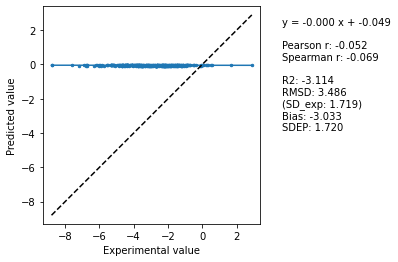

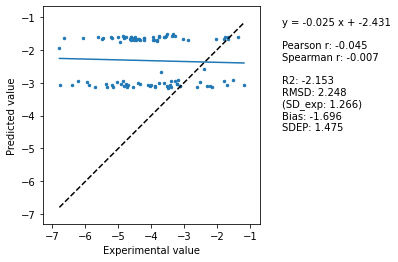

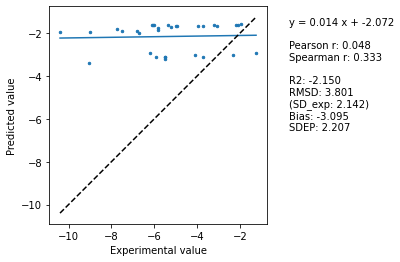

In [207]:
# plt_scatter(y, rf.predict(x[x.columns & ext_x['tight'].columns & ext_x['loose'].columns]))
# plt_scatter(y, rf.predict(x[x.columns & ext_x['tight'].columns & ext_x['loose'].columns]))
train_pred = np.zeros(len(y))
for r in range(n_ensemble):
    train_pred += rf[r].predict(x[x.columns & ext_x['tight'].columns & ext_x['loose'].columns])
    train_pred /= n_ensemble
plt_scatter(y, train_pred)

for ds in ['tight', 'loose']:
    plt_scatter(ext_y[ds], ext_pred[ds])
#     plt.gca().set_aspect('equal')
#     plt.show()

In [47]:
ext_x['tight'].columns & x.columns

Index(['apol', 'ast_fraglike', 'ast_fraglike_ext', 'ast_violation',
       'ast_violation_ext', 'balabanJ', 'BCUT_PEOE_0', 'BCUT_PEOE_1',
       'BCUT_PEOE_2', 'BCUT_PEOE_3',
       ...
       'vsurf_W7', 'vsurf_W8', 'vsurf_Wp1', 'vsurf_Wp2', 'vsurf_Wp3',
       'vsurf_Wp4', 'vsurf_Wp5', 'vsurf_Wp6', 'vsurf_Wp7', 'vsurf_Wp8'],
      dtype='object', length=299)

In [157]:
x.columns[np.argsort(rf.feature_importances_)[::-1]]

Index(['SlogP', 'logP(o/w)', 'SMR_VSA5', 'vsurf_Wp1', 'chi1_C', 'h_logP',
       'h_logD', 'PEOE_VSA+1', 'vsurf_Wp2', 'balabanJ',
       ...
       'b_triple', 'Q_PC+', 'Q_VSA_FPOL', 'Q_VSA_FPNEG', 'Q_VSA_FNEG',
       'Q_VSA_FHYD', 'Q_RPC-', 'Q_RPC+', 'Q_PC-', 'RPC+'],
      dtype='object', length=359)

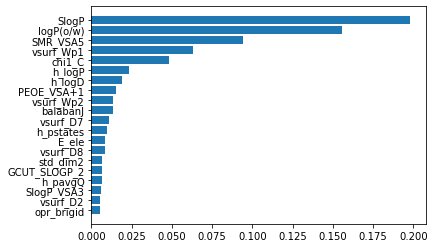

In [162]:
plt.barh(x.columns[np.argsort(rf.feature_importances_)[::-1]][:20], np.sort(rf.feature_importances_)[::-1][:20])
plt.gca().invert_yaxis()

In [50]:
set(ext_x['tight'].columns) - set(x.columns)

{'E_rele',
 'E_rnb',
 'E_rsol',
 'E_rvdw',
 'a_IC',
 'a_ICM',
 'a_acc',
 'a_acid',
 'a_aro',
 'a_base',
 'a_count',
 'a_don',
 'a_donacc',
 'a_heavy',
 'a_hyd',
 'a_nB',
 'a_nBr',
 'a_nC',
 'a_nChiralR',
 'a_nChiralRCons',
 'a_nChiralS',
 'a_nChiralSCons',
 'a_nCl',
 'a_nF',
 'a_nH',
 'a_nI',
 'a_nN',
 'a_nO',
 'a_nP',
 'a_nS',
 'b_1rotN',
 'b_1rotR',
 'b_ar',
 'b_count',
 'b_double',
 'b_heavy',
 'b_max1len',
 'b_rotN',
 'b_rotR',
 'b_single',
 'b_triple',
 'dipoleX',
 'dipoleY',
 'dipoleZ',
 'h_ema',
 'h_emd',
 'h_emd_C',
 'h_logD',
 'h_logP',
 'h_log_dbo',
 'h_log_pbo',
 'h_mr',
 'h_pKa',
 'h_pKb',
 'h_pavgQ',
 'h_pstates',
 'h_pstrain',
 'pmiX',
 'pmiY',
 'pmiZ'}

In [51]:
set(x.columns) - set(ext_x['tight'].columns)

{'1rotN',
 '1rotR',
 'IC',
 'ICM',
 'acc',
 'acid',
 'ar',
 'aro',
 'base',
 'count',
 'count-1',
 'don',
 'donacc',
 'double',
 'ema',
 'emd',
 'emd_C',
 'heavy',
 'heavy-1',
 'hyd',
 'logD',
 'logP',
 'log_dbo',
 'log_pbo',
 'max1len',
 'mr-1',
 'nB',
 'nBr',
 'nC',
 'nChiralR',
 'nChiralRCons',
 'nChiralS',
 'nChiralSCons',
 'nCl',
 'nF',
 'nH',
 'nI',
 'nN',
 'nO',
 'nP',
 'nS',
 'pKa',
 'pKb',
 'pavgQ',
 'pstates',
 'pstrain',
 'rotN',
 'rotR',
 'single',
 'triple'}

In [1]:
import sys

In [2]:
sys.path.insert(0, '/users/xpb20111/programs/benchmark_models')

In [3]:
from models import *

In [9]:
import models.RF as RF

In [10]:
dir(RF)

['GridSearchCV',
 'KFold',
 'Pipeline',
 'RFECV',
 'RandomForestRegressor',
 'RandomizedSearchCV',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'bootstrap',
 'cv_tuning_stats',
 'get_trained_params',
 'init_param_grid',
 'init_params',
 'max_depth',
 'max_features',
 'min_samples_leaf',
 'min_samples_split',
 'n_estimators',
 'np',
 'pd',
 'tune_train_model']